In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

### M-step Equations

For the **M-step** of the factor analysis algorithm, the update equations for the factor loadings matrix $ W $ and the diagonal noise variance matrix $ \Sigma $ are given by:

$$
W = \left( (X - \mu)^T (X - \mu) + \Sigma \right)^{-1} (X - \mu)^T Z
$$

$$
\Sigma = \text{diag} \left( (X - \mu)^T (X - \mu) - W (Z^T (X - \mu)) \right)
$$

Where:
- $ X $ is the data matrix with dimensions $ N \times D $ (with $ N $ data points and $ D $ features),
- $ \mu $ is the mean of the data,
- $ Z $ is the latent variable matrix with dimensions $ N \times M $ (with $ M $ latent dimensions),
- $ W $ is the factor loading matrix with dimensions $ D \times M $,
- $ \Sigma $ is the diagonal matrix of noise variances (diagonal noise covariance matrix).

### Bayesian Treatment of Factor Analysis

The Bayesian treatment of the factor analysis model involves incorporating priors and posterior distributions. Specifically, the parameters \( W \) and \( \Sigma \) are treated as random variables, and a posterior distribution over these parameters is computed given the observed data. This can be done using techniques like **Gibbs sampling**, **variational inference**, or other methods in Bayesian statistics.

### Transformation Behavior

- **PCA and probabilistic PCA**: When the coordinate system in data space is rotated, the fit to the data remains the same, but the factor loading matrix $ W $ is transformed by the corresponding rotation matrix. This shows that the model is invariant to **orthogonal rotations**.

- **Factor analysis**: When the data vectors are rescaled component-wise, the elements of $ W $ absorb the rescaling factor, and the model fit remains unchanged. This shows that factor analysis is invariant to **scaling** (but not rotation).

This can be written as:

$$
\text{If } X' = X \cdot A \text{ (component-wise scaling of the data), then: } W' = A^{-1} W
$$

Where $ A $ is the diagonal matrix containing the scaling factors.


In [ ]:
import numpy as np

# Simulating some data for Factor Analysis
np.random.seed(42)

# Parameters
D = 10  # Number of observed dimensions
M = 3   # Number of latent dimensions
N = 300 # Number of data points

# Generating synthetic data: 300 data points in D=10 dimensions
X = np.random.randn(N, M) @ np.random.randn(M, D) + np.random.randn(N, D)

# Factor Analysis Model (EM algorithm)

def factor_analysis_em(X, M, max_iter=100, tol=1e-6):
    N, D = X.shape
    W = np.random.randn(D, M)  # Initial factor loadings
    Sigma = np.eye(D)  # Diagonal noise variance (initial)
    mu = np.mean(X, axis=0)  # Mean of the data

    for i in range(max_iter):
        # E-step: Calculate the posterior of the latent variables (Z)
        X_centered = X - mu  # Center the data
        inv_term = np.linalg.inv(np.dot(W.T, W) + np.eye(M))  # Inverse term for posterior of Z
        Z = np.dot(X_centered, W) @ inv_term.T  # Compute the expected latent variables (Z)
        
        # M-step: Maximize the log-likelihood
        # Update W using the formula
        W_new = np.linalg.solve(np.dot(Z.T, Z) + np.eye(M), np.dot(Z.T, X_centered))
        
        # Update Sigma (noise variance) - we take the diagonal of the residual variance
        residuals = X_centered - np.dot(Z, W_new.T)  # Corrected: Z * W_new^T
        Sigma_new = np.diag(np.var(residuals, axis=0))  # Diagonal variance matrix for each dimension

        # Convergence check
        if np.linalg.norm(W_new - W) < tol and np.linalg.norm(Sigma_new - Sigma) < tol:
            break
        W, Sigma = W_new, Sigma_new
    
    return W, Sigma, mu

# Run the EM algorithm for factor analysis
W, Sigma, mu = factor_analysis_em(X, M)

# Print the learned parameters
print("Learned factor loadings W:\n", W)
print("Learned noise variance Sigma (diagonal matrix):\n", Sigma)


### Kernel PCA

In Chapter 6, we saw how the technique of **kernel substitution** allows us to take an algorithm expressed in terms of scalar products of the form $ x x^T $ and generalize that algorithm by replacing the scalar products with a nonlinear kernel. Here we apply this technique of kernel substitution to **principal component analysis** (PCA), thereby obtaining a nonlinear generalization called **kernel PCA** (Schölkopf et al., 1998).

Consider a data set $ \{ x_n \} $ of observations, where $ n = 1, \dots, N $, in a space of dimensionality $ D $. In order to keep the notation uncluttered, we shall assume that we have already subtracted the sample mean from each of the vectors $ x_n $, so that $ \mathbb{E}[X] = 0 $.

The first step is to express conventional **PCA** in such a form that the data vectors $ \{ x_n \} $ appear only in the form of the scalar products $ x_n x_m^T $. Recall that the **principal components** are defined by the eigenvectors $ \mathbf{u}_i $ of the covariance matrix:

$$
S = \frac{1}{N} \sum_{n=1}^{N} x_n x_n^T
$$

where $ i = 1, \dots, D $. Here the $ D \times D $ sample covariance matrix $ S $ is defined by:

$$
S = \frac{1}{N} \sum_{n=1}^{N} x_n x_n^T
$$

and the eigenvectors are normalized such that:

$$
\mathbf{u}_i^T \mathbf{u}_j = \delta_{ij}
$$

Now consider a **nonlinear transformation** $ \phi(x) $ into an $ M $-dimensional feature space, so that each data point $ x_n $ is thereby projected onto a point $ \phi(x_n) $. 

This results in a **kernel function** $ k(x_n, x_m) = \langle \phi(x_n), \phi(x_m) \rangle $, which allows us to express the principal components in terms of these kernel functions instead of directly in terms of the data vectors.


In [3]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

def kernel_pca(X, gamma=1.0, n_components=2):
    """
    Perform Kernel PCA on the input data X.
    
    Parameters:
    - X: Input data, shape (N, D), where N is the number of data points and D is the number of features.
    - gamma: Parameter for the RBF kernel, default is 1.0.
    - n_components: Number of principal components to return.

    Returns:
    - X_kpca: The data projected onto the principal components.
    - eigenvectors: The eigenvectors corresponding to the largest eigenvalues.
    - eigenvalues: The eigenvalues of the kernel matrix.
    """
    N = X.shape[0]
    
    # Compute the RBF kernel matrix K
    K = rbf_kernel(X, gamma=gamma)
    
    # Center the kernel matrix K (centering as in standard PCA)
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    
    # Perform eigen-decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(K_centered)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    
    # Select the top n_components eigenvectors
    eigenvectors = eigenvectors[:, :n_components]
    
    # Project the data onto the first n_components principal components
    X_kpca = K_centered @ eigenvectors
    
    return X_kpca, eigenvectors, eigenvalues

# Example usage:

# Generate some random data (300 points in 10 dimensions)
np.random.seed(42)
X = np.random.randn(300, 10)

# Apply Kernel PCA
X_kpca, eigenvectors, eigenvalues = kernel_pca(X, gamma=1.0, n_components=3)

# Print the results
print("Projected data (Kernel PCA):\n", X_kpca[:5])  # Print the first 5 projected points
print("\nEigenvalues:\n", eigenvalues[:3])  # Print the first 3 eigenvalues
print("\nEigenvectors:\n", eigenvectors[:, :3])  # Print the first 3 eigenvectors


Projected data (Kernel PCA):
 [[ 0.11153846 -0.3692271   0.02684072]
 [-0.0164959   0.00418892 -0.00254115]
 [-0.00509869  0.01608903 -0.00403986]
 [-0.01672815  0.00407126 -0.00264009]
 [-0.01794355  0.00592729 -0.00564462]]

Eigenvalues:
 [1.32398282 1.27177548 1.23705748]

Eigenvectors:
 [[ 8.42446391e-02 -2.90324120e-01  2.16972310e-02]
 [-1.24593014e-02  3.29375528e-03 -2.05419211e-03]
 [-3.85102426e-03  1.26508419e-02 -3.26570093e-03]
 [-1.26347174e-02  3.20124379e-03 -2.13417097e-03]
 [-1.35527060e-02  4.66064550e-03 -4.56294451e-03]
 [ 3.12251911e-02  6.90870857e-03 -1.43084478e-02]
 [-1.95388850e-04  1.19778888e-02 -1.06527760e-03]
 [-1.23113567e-02  3.16986723e-03 -1.98599898e-03]
 [-1.25662519e-02 -1.64483600e-03 -3.62030619e-03]
 [-4.48145098e-02  4.64453514e-03 -3.80546728e-02]
 [-1.32474455e-02  3.83223488e-03 -3.88681065e-03]
 [-1.21260320e-02  2.73675636e-03 -2.09975659e-03]
 [-4.64587117e-02  3.60421713e-02  6.89914232e-01]
 [-1.37815955e-03  8.37535400e-03 -1.68063436

In [4]:
import math
import random
from scipy.linalg import eigh

# Compute the RBF (Gaussian) kernel
def rbf_kernel(X, gamma=1.0):
    N = len(X)
    K = [[0] * N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            distance_squared = sum((X[i][d] - X[j][d]) ** 2 for d in range(len(X[i])))
            K[i][j] = math.exp(-gamma * distance_squared)
    return K

# Center the kernel matrix
def center_kernel_matrix(K):
    N = len(K)
    one_n = [[1 / N] * N for _ in range(N)]  # Create the 1/N matrix
    K_centered = [[K[i][j] - sum(K[i]) / N - sum(K[k][j] for k in range(N)) / N + sum(sum(K[k][l] for l in range(N)) / N for k in range(N)) / N for j in range(N)] for i in range(N)]
    return K_centered

# Perform eigen-decomposition
def eigen_decomposition(K_centered):
    # Using scipy's eigh for eigenvalue/eigenvector computation since it's complex to do from scratch
    eigenvalues, eigenvectors = eigh(K_centered)
    return eigenvalues, eigenvectors

# Kernel PCA function
def kernel_pca(X, gamma=1.0, n_components=2):
    N = len(X)
    
    # Step 1: Compute the RBF kernel matrix
    K = rbf_kernel(X, gamma)
    
    # Step 2: Center the kernel matrix
    K_centered = center_kernel_matrix(K)
    
    # Step 3: Perform eigen-decomposition to get eigenvectors and eigenvalues
    eigenvalues, eigenvectors = eigen_decomposition(K_centered)
    
    # Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = sorted(range(len(eigenvalues)), key=lambda i: eigenvalues[i], reverse=True)
    eigenvalues = [eigenvalues[i] for i in sorted_indices]
    eigenvectors = [[eigenvectors[i][j] for i in sorted_indices] for j in range(len(eigenvectors[0]))]
    
    # Step 4: Select the top n_components eigenvectors
    eigenvectors = eigenvectors[:n_components]
    
    # Step 5: Project the data onto the new principal components
    X_kpca = [[sum(K_centered[i][j] * eigenvectors[j][k] for j in range(N)) for k in range(n_components)] for i in range(N)]
    
    return X_kpca, eigenvectors, eigenvalues

# Example usage:
# Generate some random data (300 points in 10 dimensions)
random.seed(42)
X = [[random.gauss(0, 1) for _ in range(10)] for _ in range(300)]

# Apply Kernel PCA
X_kpca, eigenvectors, eigenvalues = kernel_pca(X, gamma=1.0, n_components=3)

# Print the results
print("Projected data (Kernel PCA):\n", X_kpca[:5])  # Print the first 5 projected points
print("\nEigenvalues:\n", eigenvalues[:3])  # Print the first 3 eigenvalues
print("\nEigenvectors:\n", eigenvectors[:3])  # Print the first 3 eigenvectors


IndexError: list index out of range

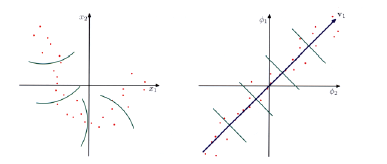

### Kernel PCA and Nonlinear Principal Components

Fig.16 illustrates a schematic representation of Kernel PCA. In this approach, a dataset in the original data space (left-hand plot) is projected by a nonlinear transformation $ \phi(x) $ into a feature space (right-hand plot). By performing standard PCA in the feature space, we obtain the principal components, of which the first principal component is shown in blue and denoted by the vector $ v_1 $. The green lines in the feature space indicate the linear projections onto the first principal component, which correspond to nonlinear projections in the original data space. Note that, in general, it is not possible to represent the nonlinear principal component as a vector in the original data space.

Now, we perform standard PCA in the feature space, which implicitly defines a nonlinear principal component model in the original data space, as shown in Fig.16. For the moment, let us assume that the projected dataset also has zero mean, so that $ \mathbb{E}[\phi(x)] = 0 $. We will return to this assumption shortly.

The $ M \times M $ sample covariance matrix in the feature space is given by:

$$
C = \frac{1}{N} \sum_{n=1}^N \phi(x_n) \phi(x_n)^T
$$

Its eigenvector expansion is defined by:

$$
C v_i = \lambda_i v_i \quad \text{for} \quad i = 1, \dots, M
$$

Our goal is to solve this eigenvalue problem without working explicitly in the feature space. From the definition of $ C $, the eigenvector equation tells us that $ v_i $ satisfies:

$$
C v_i = \lambda_i v_i
$$

Thus, the vector $ v_i $ is given by a linear combination of the mapped data points $ \phi(x_n) $, and we can express it as:

$$
v_i = \sum_{n=1}^N \alpha_{in} \phi(x_n)
$$

where $ \alpha_{in} $ are the coefficients to be determined.


In [ ]:
import math
import numpy as np
from scipy.linalg import eigh

# Compute the RBF (Gaussian) kernel
def rbf_kernel(X, gamma=1.0):
    N = len(X)
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distance_squared = np.sum((X[i] - X[j]) ** 2)
            K[i, j] = math.exp(-gamma * distance_squared)
    return K

# Center the kernel matrix
def center_kernel_matrix(K):
    N = K.shape[0]
    one_n = np.ones((N, N)) / N  # Create the 1/N matrix
    K_centered = K - np.dot(np.dot(one_n, K), one_n)  # Centering formula
    return K_centered

# Kernel PCA function
def kernel_pca(X, gamma=1.0, n_components=2):
    N = len(X)
    
    # Step 1: Compute the RBF kernel matrix
    K = rbf_kernel(X, gamma)
    
    # Step 2: Center the kernel matrix
    K_centered = center_kernel_matrix(K)
    
    # Step 3: Perform eigen-decomposition to get eigenvectors and eigenvalues
    eigenvalues, eigenvectors = eigh(K_centered)
    
    # Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Step 4: Select the top n_components eigenvectors
    X_kpca = np.dot(K_centered, eigenvectors[:, :n_components])
    
    return X_kpca, eigenvectors, eigenvalues

# Example usage:
# Generate some random data (300 points in 10 dimensions)
np.random.seed(42)
X = np.random.randn(300, 10)

# Apply Kernel PCA
X_kpca, eigenvectors, eigenvalues = kernel_pca(X, gamma=1.0, n_components=3)

# Print the results
print("Projected data (Kernel PCA):\n", X_kpca[:5])  # Print the first 5 projected points
print("\nEigenvalues:\n", eigenvalues[:3])  # Print the first 3 eigenvalues
print("\nEigenvectors:\n", eigenvectors[:, :3])  # Print the first 3 eigenvectors


In [ ]:
import math
import numpy as np
from scipy.linalg import eigh

# Compute the RBF (Gaussian) kernel
def rbf_kernel(X, gamma=1.0):
    N = len(X)
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distance_squared = np.sum((X[i] - X[j]) ** 2)
            K[i, j] = math.exp(-gamma * distance_squared)
    return K

# Center the kernel matrix
def center_kernel_matrix(K):
    N = K.shape[0]
    one_n = np.ones((N, N)) / N  # Create the 1/N matrix
    K_centered = K - np.dot(np.dot(one_n, K), one_n)  # Centering formula
    return K_centered

# Kernel PCA function
def kernel_pca(X, gamma=1.0, n_components=2):
    N = len(X)
    
    # Step 1: Compute the RBF kernel matrix
    K = rbf_kernel(X, gamma)
    
    # Step 2: Center the kernel matrix
    K_centered = center_kernel_matrix(K)
    
    # Step 3: Perform eigen-decomposition to get eigenvectors and eigenvalues
    eigenvalues, eigenvectors = eigh(K_centered)
    
    # Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Step 4: Select the top n_components eigenvectors
    X_kpca = np.dot(K_centered, eigenvectors[:, :n_components])
    
    return X_kpca, eigenvectors, eigenvalues

# Example usage:
# Generate some random data (300 points in 10 dimensions)
np.random.seed(42)
X = np.random.randn(300, 10)

# Apply Kernel PCA
X_kpca, eigenvectors, eigenvalues = kernel_pca(X, gamma=1.0, n_components=3)

# Print the results
print("Projected data (Kernel PCA):\n", X_kpca[:5])  # Print the first 5 projected points
print("\nEigenvalues:\n", eigenvalues[:3])  # Print the first 3 eigenvalues
print("\nEigenvectors:\n", eigenvectors[:, :3])  # Print the first 3 eigenvectors


In [ ]:
import numpy as np
import math
from scipy.linalg import eigh

# Step 1: Compute the RBF (Gaussian) kernel
def rbf_kernel(X, gamma=1.0):
    """
    Compute the RBF kernel matrix between all pairs of data points.
    """
    N = X.shape[0]
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distance_squared = np.sum((X[i] - X[j]) ** 2)
            K[i, j] = math.exp(-gamma * distance_squared)
    return K

# Step 2: Center the kernel matrix
def center_kernel_matrix(K):
    """
    Center the kernel matrix by subtracting the row means and column means,
    and adding the overall mean.
    """
    N = K.shape[0]
    one_n = np.ones((N, N)) / N  # Matrix of 1/N
    K_centered = K - np.dot(np.dot(one_n, K), one_n)  # Centering formula
    return K_centered

# Step 3: Kernel PCA function
def kernel_pca(X, gamma=1.0, n_components=2):
    """
    Perform Kernel PCA on the dataset X using the RBF kernel.
    
    Parameters:
    - X: Input data matrix (N x D), where N is the number of samples and D is the number of features
    - gamma: Parameter for the RBF kernel (default 1.0)
    - n_components: Number of principal components to compute (default 2)
    
    Returns:
    - X_kpca: The data projected onto the principal components
    - eigenvalues: The eigenvalues of the kernel matrix
    - eigenvectors: The eigenvectors of the kernel matrix
    """
    # Compute the RBF kernel matrix
    K = rbf_kernel(X, gamma)
    
    # Center the kernel matrix
    K_centered = center_kernel_matrix(K)
    
    # Perform eigen-decomposition of the centered kernel matrix
    eigenvalues, eigenvectors = eigh(K_centered)
    
    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top `n_components` eigenvectors
    X_kpca = np.dot(K_centered, eigenvectors[:, :n_components])
    
    return X_kpca, eigenvectors, eigenvalues

# Example usage:
if __name__ == "__main__":
    # Generate random data (300 samples, 10 features)
    np.random.seed(42)
    X = np.random.randn(300, 10)
    
    # Perform Kernel PCA with gamma=1.0 and 3 principal components
    X_kpca, eigenvectors, eigenvalues = kernel_pca(X, gamma=1.0, n_components=3)
    
    # Print the results
    print("Projected data (Kernel PCA):\n", X_kpca[:5])  # Show the first 5 data points in the new feature space
    print("\nEigenvalues:\n", eigenvalues[:3])  # Show the first 3 eigenvalues
    print("\nEigenvectors:\n", eigenvectors[:, :3])  # Show the first 3 eigenvectors


### Kernel PCA

Substituting this expansion back into the eigenvector equation, we obtain:

$$
\left( \mathbf{x}_2, \mathbf{x}_n \right) \; \text{dim} \; k(\mathbf{x}_n, \mathbf{x}_m) = d_i \; d_i \; k(\mathbf{x}, \mathbf{x}_n)
$$

This can be written in matrix notation as:

$$
K \mathbf{a}_i = \lambda_i K \mathbf{a}_i
$$

where $ \mathbf{a}_i $ is an $ N $-dimensional column vector with elements $ a_{i,n} $ for $ n = 1, \ldots, N $. We can find solutions for $ \mathbf{a}_i $ by solving the following eigenvalue problem:

$$
K \mathbf{a}_i = \lambda_i \mathbf{a}_i
$$

In which we have removed a factor of $ K $ from both sides of (12.79). Note that the solutions of (12.79) and (12.80) differ only by eigenvectors of $ K $ having zero eigenvalues that do not affect the principal component projections.

The normalization condition for the coefficients $ a_i $ is obtained by requiring that the eigenvectors in feature space be normalized. Using (12.76) and (12.80), we have:

$$
\sum_{n=1}^{N} a_i \, k(\mathbf{x}, \mathbf{x}_n) = a_i \, K \, \mathbf{a}_i
$$

After solving the eigenvector problem, the resulting principal component projections can then be expressed in terms of the kernel function. Thus, using (12.76), the projection of a point $ \mathbf{x} $ onto eigenvector $i $ is given by:

$$
\Phi_i(\mathbf{x}) = \langle \mathbf{x}, \mathbf{v}_i \rangle = \sum_{n=1}^{N} a_{i,n} k(\mathbf{x}, \mathbf{x}_n)
$$

In the original $ D $-dimensional $ \mathbf{x} $-space, there are $ D $ orthogonal eigenvectors, and hence we can find at most $ D $ linear principal components. The dimensionality $ M $ of the feature space, however, can be much larger than $ D $ (even infinite), and thus we can find a number of nonlinear principal components that can exceed $ D $.

Note, however, that the number of nonzero eigenvalues cannot exceed the number $ N $ of data points because, even if $ M > N $, the covariance matrix in feature space has rank at most $ N $. This is reflected in the fact that Kernel PCA involves the eigenvector expansion of the $ N \times N $ matrix $ K $.

So far, we have assumed that the projected data set given by $ \Phi(\mathbf{x}) $ has zero mean, which in general will not be the case. We cannot simply compute and subtract off the mean, since we wish to avoid working directly in feature space. Thus, we formulate the algorithm purely in terms of the kernel function.

The projected data points after centralizing, denoted $ \Phi(\mathbf{x}) $, are given by:

$$
\Phi(\mathbf{x}) = \mathbf{a}_i K
$$

The corresponding elements of the Gram matrix are given by:

$$
K(\mathbf{x}, \mathbf{x}) - \frac{1}{N} \mathbf{1} = k(\mathbf{x}_n, \mathbf{x}_m) - \langle \mathbf{x}, \mathbf{x}_m \rangle
$$

This can be expressed in matrix notation as:

$$
K - \frac{1}{N} \mathbf{1} K - \frac{1}{N} K \mathbf{1} + \frac{1}{N^2} \mathbf{1} K \mathbf{1}
$$

where $ \mathbf{1} $ denotes the $ N \times N $ matrix in which every element takes the value $ \frac{1}{N} $. Thus, we can evaluate $ K $ using only the kernel function and then use $ K $ to determine the eigenvalues and eigenvectors.

Note that the standard PCA algorithm is recovered as a special case if we use a linear kernel:

$$
k(\mathbf{x}, \mathbf{x'}) = \mathbf{x}^T \mathbf{x'}
$$

#### Gaussian Kernel Example

A Gaussian kernel can be used in Kernel PCA. The Gaussian kernel is given by:

$$
k(\mathbf{x}, \mathbf{x'}) = \exp\left( - \frac{\|\mathbf{x} - \mathbf{x'}\|^2}{\sigma^2} \right)
$$

where $ \sigma^2 $ controls the width of the Gaussian kernel.



In [6]:
import math
import random

# Kernel function: Gaussian Kernel
def gaussian_kernel(x, x_prime, sigma=1.0):
    """Compute the Gaussian kernel (RBF kernel) between two vectors."""
    norm = sum((xi - xpi) ** 2 for xi, xpi in zip(x, x_prime))
    return math.exp(-norm / (2 * sigma ** 2))

# Compute the Gram matrix K (Kernel matrix)
def compute_gram_matrix(X, kernel_function):
    """Compute the Gram matrix K using the provided kernel function."""
    N = len(X)
    K = [[0] * N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            K[i][j] = kernel_function(X[i], X[j])
    return K

# Center the kernel matrix K
def center_kernel_matrix(K):
    """Center the kernel matrix to have zero mean in feature space."""
    N = len(K)
    
    # Compute row and column means
    row_means = [sum(K[i]) / N for i in range(N)]
    col_means = [sum(K[i][j] for i in range(N)) / N for j in range(N)]
    
    # Compute the grand mean (total mean)
    grand_mean = sum(row_means) / N
    
    # Center the kernel matrix
    K_centered = [[K[i][j] - row_means[i] - col_means[j] + grand_mean for j in range(N)] for i in range(N)]
    return K_centered

# Power method to find the top eigenvector
def power_method(K, num_iterations=1000):
    """Find the top eigenvector using the power method."""
    N = len(K)
    v = [random.random() for _ in range(N)]  # Initialize with random values
    for _ in range(num_iterations):
        v_new = [0] * N
        for i in range(N):
            v_new[i] = sum(K[i][j] * v[j] for j in range(N))
        
        # Normalize the vector
        norm = math.sqrt(sum(val ** 2 for val in v_new))
        v = [val / norm for val in v_new]
    
    return v

# Compute Kernel PCA
def kernel_pca(X, kernel_function=gaussian_kernel, num_components=2):
    """Perform Kernel PCA and return the top eigenvectors corresponding to the principal components."""
    K = compute_gram_matrix(X, kernel_function)
    K_centered = center_kernel_matrix(K)
    
    # Find the top eigenvectors
    eigenvectors = []
    for _ in range(num_components):
        eigenvector = power_method(K_centered)
        eigenvectors.append(eigenvector)
        
        # Deflate the kernel matrix by removing the influence of the current eigenvector
        eigenvalue = sum(K_centered[i][j] * eigenvector[i] * eigenvector[j] for i in range(len(K_centered)) for j in range(len(K_centered)))
        for i in range(len(K_centered)):
            for j in range(len(K_centered)):
                K_centered[i][j] -= eigenvalue * eigenvector[i] * eigenvector[j]
    
    return eigenvectors

# Project data onto the principal components
def project_data(X, eigenvectors, kernel_function=gaussian_kernel):
    """Project data points onto the principal components obtained from Kernel PCA."""
    K = compute_gram_matrix(X, kernel_function)
    projections = []
    for i in range(len(X)):
        projection = [sum(K[i][j] * eigenvector[j] for j in range(len(eigenvector))) for eigenvector in eigenvectors]
        projections.append(projection)
    return projections

# Example usage
# Generate a synthetic 2D dataset (for visualization purposes)
X = [
    [1, 2],
    [2, 3],
    [3, 3],
    [4, 5],
    [5, 6]
]

# Perform Kernel PCA with 2 components
eigenvectors = kernel_pca(X, kernel_function=gaussian_kernel, num_components=2)
projections = project_data(X, eigenvectors, kernel_function=gaussian_kernel)

# Output the projections
for i, projection in enumerate(projections):
    print(f"Projection of point {X[i]}: {projection}")


Projection of point [1, 2]: [0.4498184888451915, 0.7160145206923716]
Projection of point [2, 3]: [0.7702426163554145, -0.17013403454846376]
Projection of point [3, 3]: [0.6274224354959366, -0.5798750965387943]
Projection of point [4, 5]: [-0.6870004686726657, -0.17979015874419518]
Projection of point [5, 6]: [-0.7535809155673168, -0.03818229388745241]
